In [1]:
import sys
sys.path.insert(0, '../')

In [2]:
import time
import torch
import numpy as np
import os
import pickle
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
import traceback

from scripts import tabular_metrics
from scripts.differentiable_pfn_evaluation import eval_model, eval_model_range
from scripts.model_builder import get_model, get_default_spec, save_model, load_model, load_model_only_inference
from scripts.transformer_prediction_interface import transformer_predict, get_params_from_config, TabPFNClassifier

from datasets import load_openml_list, open_cc_dids, open_cc_valid_dids, test_dids_classification


In [3]:
base_path = '.'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load Datasets

In [4]:
max_samples = 10000
bptt = 10000

cc_test_datasets_multiclass, cc_test_datasets_multiclass_df = load_openml_list(open_cc_dids, multiclass=True, shuffled=True, filter_for_nan=False, max_samples = max_samples, num_feats=100, return_capped=True)
cc_valid_datasets_multiclass, cc_valid_datasets_multiclass_df = load_openml_list(open_cc_valid_dids, multiclass=True, shuffled=True, filter_for_nan=False, max_samples = max_samples, num_feats=100, return_capped=True)

# Loading longer OpenML Datasets for generalization experiments (optional)
# test_datasets_multiclass, test_datasets_multiclass_df = load_openml_list(test_dids_classification, multiclass=True, shuffled=True, filter_for_nan=False, max_samples = 10000, num_feats=100, return_capped=True)

# Set the seed for the random number generator provided by PyTorch
torch.manual_seed(0)

# Set the seed for the random number generator provided by NumPy
np.random.seed(0)

random.seed(0)
random.shuffle(cc_valid_datasets_multiclass)

Number of datasets: 30
Loading balance-scale 11 ..
Loading mfeat-fourier 14 ..
Loading breast-w 15 ..
Loading mfeat-karhunen 16 ..
Loading mfeat-morphological 18 ..
Loading mfeat-zernike 22 ..
Loading cmc 23 ..
Loading credit-approval 29 ..
Loading credit-g 31 ..
Loading diabetes 37 ..
Loading tic-tac-toe 50 ..
Loading vehicle 54 ..
Loading eucalyptus 188 ..
Loading analcatdata_authorship 458 ..
Loading analcatdata_dmft 469 ..
Loading pc4 1049 ..
Loading pc3 1050 ..
Loading kc2 1063 ..
Loading pc1 1068 ..
Loading banknote-authentication 1462 ..
Loading blood-transfusion-service-center 1464 ..
Loading ilpd 1480 ..
Loading qsar-biodeg 1494 ..
Loading wdbc 1510 ..
Loading cylinder-bands 6332 ..
Loading dresses-sales 23381 ..
Loading MiceProtein 40966 ..
Loading car 40975 ..
Loading steel-plates-fault 40982 ..
Loading climate-model-simulation-crashes 40994 ..
Number of datasets: 150
Loading breast-cancer 13 ..
Loading colic 25 ..
Loading dermatology 35 ..
Loading sonar 40 ..
Loading glass 

In [5]:
def get_datasets(selector, task_type, suite='cc'):
    if task_type == 'binary':
        ds = valid_datasets_binary if selector == 'valid' else test_datasets_binary
    else:
        if suite == 'openml':
            ds = valid_datasets_multiclass if selector == 'valid' else test_datasets_multiclass
        elif suite == 'cc':
            ds = cc_valid_datasets_multiclass if selector == 'valid' else cc_test_datasets_multiclass
        else:
            raise Exception("Unknown suite")
    return ds

In [6]:
model_string, longer, task_type = '', 1, 'multiclass'
eval_positions = [1000]
bptt = 2000
    
test_datasets, valid_datasets = get_datasets('test', task_type, suite='cc'), get_datasets('valid', task_type, suite='cc')

# Pick single Dataset

In [7]:
evaluation_dataset_index = 8 # Index of the dataset to predict
ds = test_datasets[evaluation_dataset_index]
print(f'Evaluation dataset name: {ds[0]} shape {ds[1].shape}')

Evaluation dataset name: credit-g shape torch.Size([1000, 20])


## Split x and y in train and test

In [8]:
xs, ys = ds[1].clone(), ds[2].clone()
eval_position = xs.shape[0] // 2
train_xs, train_ys = xs[0:eval_position], ys[0:eval_position]
test_xs, test_ys = xs[eval_position:], ys[eval_position:]

## weighting for the ensemble (AUC/CE)

In [9]:
class PFNEnsemble:
    def __init__(self, 
                 model_storage_folders=["models_gp"],
                 device="cpu",
                 N_ensemble_configurations=5,
                 verbose=False):
        # Maps model_index to loaded model
        self.model_dict = {}
        self.data_ens_dict = {}
        
        for model_storage_folder in model_storage_folders:
            # Iterate over all files in the model_path directory
            for model_index, model_string in enumerate(os.listdir(model_storage_folder)):
                if model_string.endswith('.cpkt'):  # Assuming the models have a .cpkt extension
                    loaded_model = TabPFNClassifier(base_path=model_storage_folder,
                                                    model_string=model_string[:-5],
                                                    N_ensemble_configurations=N_ensemble_configurations,
                                                    batch_size_inference=1, 
                                                    no_preprocess_mode=True)
                    
        
                    self.model_dict[model_string.split('.')[0]] = {"model": loaded_model}

    def fit(self, train_xs, train_ys):
        for model_name, model_content in self.model_dict.items():
            model = model_content["model"]
            model.fit(train_xs, train_ys)
            
    def get_split_of_train_data_simple(self, train_x, train_y, split_share):
        temp_split_pos = int(train_x.shape[0] * split_share)
        
        temp_split_train_x = train_x[:temp_split_pos]
        temp_split_test_x = train_x[temp_split_pos:]
        
        temp_split_train_y = train_y[:temp_split_pos]
        temp_split_test_y = train_y[temp_split_pos:]
        return [(temp_split_train_x, temp_split_test_x, temp_split_train_y, temp_split_test_y)]
    
                
    def get_split_of_train_data_bagging(self, train_x, train_y, split_share, number_splits):
        splits = [] # each entry has format: [(temp_split_train_x, temp_split_test_x, temp_split_train_y, temp_split_test_y)]
        # todo repeat the following number_splits times and add each time to splits
        for i in range(number_splits):
            temp_split_indices = random.sample(range(len(train_x)), int(split_share * len(train_x)))
            temp_split_train_x = [train_x[i] for i in temp_split_indices]
            temp_split_test_x = [train_x[i] for i in range(len(train_x)) if i not in temp_split_indices]

            temp_split_train_y = [train_y[i] for i in temp_split_indices]
            temp_split_test_y = [train_y[i] for i in range(len(train_y)) if i not in temp_split_indices]
            splits.append((temp_split_train_x, temp_split_test_x, temp_split_train_y, temp_split_test_y))
        return splits
    
    
    def get_split_of_train_data_pasting(self, train_x, train_y, split_share):
        splits = [] # each entry has format: [(temp_split_train_x, temp_split_test_x, temp_split_train_y, temp_split_test_y)]
        # todo repeat the following number_splits times and add each time to splits
        list_of_indices_to_sample = list(range(len(train_x)))
        while len(list_of_indices_to_sample) > 1: # need at least two 
            len_list_to_sample = len(list_of_indices_to_sample)
            if len_list_to_sample <= int(split_share * len(train_x)) * 2:
                temp_split_train_indices = list_of_indices_to_sample[:len_list_to_sample//2]
                temp_split_test_indices = list_of_indices_to_sample[len_list_to_sample//2:]
            else:    
                temp_split_train_indices = random.sample(list_of_indices_to_sample, int(split_share * len(train_x)))
                remaining_list_indices = [x for x in list_of_indices_to_sample if x not in temp_split_train_indices]
                temp_split_test_indices = random.sample(remaining_list_indices,int(split_share * len(train_x)))
                
            # remove indices which has been sampled in temp_split_indices from list_of_indices_to_sample
            list_of_indices_to_sample  = [x for x in list_of_indices_to_sample if x not in temp_split_train_indices + temp_split_test_indices]

            temp_split_train_x = [train_x[i] for i in temp_split_train_indices]
            temp_split_test_x = [train_x[i] for i in temp_split_test_indices]

            temp_split_train_y = [train_y[i] for i in temp_split_train_indices]
            temp_split_test_y = [train_y[i] for i in temp_split_test_indices]

            splits.append((temp_split_train_x, temp_split_test_x, temp_split_train_y, temp_split_test_y))
        return splits
            
        
    def get_train_auc_of_model(self,model,splits): 
        total_auc = 0
        for temp_split_train_x, temp_split_test_x, temp_split_train_y, temp_split_test_y in splits:
            model.fit(temp_split_train_x, temp_split_train_y)
            prediction_ = model.predict_proba(temp_split_test_x)
            auc = tabular_metrics.auc_metric(temp_split_test_y, prediction_)
            total_auc += auc
        total_auc /= len(splits)
        return total_auc
        
    def compute_weights(self, level, weight_type):
        
        if weight_type == f"weighted_average":
            if level == 'data':
                sum_of_auc = {}
                for key in self.data_ens_dict.keys():
                    model_name = key.split('-')[0]
                    if model_name not in sum_of_auc.keys():
                        sum_of_auc[model_name] = 0
                    sum_of_auc[model_name] += self.data_ens_dict[key][f'{level}_auc']
                    
                for data_ens_key, data_ens_content in self.data_ens_dict.items():
                    self.data_ens_dict[data_ens_key][f"{level}_weight"] = data_ens_content[f"{level}_auc"] / sum_of_auc[data_ens_key.split('-')[0]]
                
            else: # model here
                sum_of_auc = sum([i[f'{level}_auc'] for i in self.model_dict.values()])

                for ensemble_index, model_name in self.model_dict.items():
                    self.model_dict[ensemble_index][f"{level}_weight"] = self.model_dict[ensemble_index][f"{level}_auc"] / sum_of_auc
                
        elif weight_type == f"best_performer":
            
            if level == 'data':
                max_aucs = {}
                for key in self.data_ens_dict.keys():
                    model_name = key.split('-')[0]
                    if model_name not in max_aucs.keys():
                        max_aucs[model_name] = self.data_ens_dict[key][f'{level}_auc']
                    max_aucs[model_name] = max(max_aucs[model_name], self.data_ens_dict[key][f'{level}_auc'])
                
                max_auc_keys = {}
                for data_ens_key, data_ens_content in self.data_ens_dict.items():
                    if data_ens_content[f'{level}_auc'] == max_aucs[data_ens_key.split('-')[0]]:
                        max_auc_keys[data_ens_key.split('-')[0]] = data_ens_key
                
                for data_ens_key in self.data_ens_dict.keys():
                    if data_ens_key in max_auc_keys.values():
                        self.data_ens_dict[data_ens_key][f'{level}_weight'] = 1
                    else:
                        self.data_ens_dict[data_ens_key][f'{level}_weight'] = 0
                
            else:
                max_model_auc = max([i[f'{level}_auc'] for i in self.model_dict.values()])
                
                max_auc_key = None
                for model_key, model_content in self.model_dict.items():
                    if model_content[f'{level}_auc'] == max_model_auc:
                        max_auc_key = model_key
                        break
                
                for model_key in self.model_dict.keys():
                    if model_key == max_auc_key:
                        self.model_dict[model_key][f'{level}_weight'] = 1
                    else:
                        self.model_dict[model_key][f'{level}_weight'] = 0

        
    def get_splits_of_train_data(self, full_train_x, full_train_y, split_type, split_share, number_splits):
        # compute the train data splits for later AUC computation
        if split_type == "simple":
            return self.get_split_of_train_data_simple(train_x=full_train_x, train_y=full_train_y, split_share=split_share)
        elif split_type == "bagging":
            return self.get_split_of_train_data_bagging(train_x=full_train_x, train_y=full_train_y, split_share=split_share,number_splits=number_splits)
        elif split_type == "pasting": 
            return self.get_split_of_train_data_pasting(train_x=full_train_x, train_y=full_train_y, split_share=split_share)
        else:
            print("todo raise error")
        
        
    def predict_proba(self, 
                      test_xs, 
                      data_ensemble_config = None,
                      model_ensemble_config = None,
                      data_preprocess_config = None, 
                      multiple_models=False,
                      pre_processing=False ):
        
         # ------------------- only preprocessing with one model --------------------------
        if multiple_models is False and pre_processing is True:
            print("predict_proba use only the baseline model and data-ensembling as no moe config is given! ")
            
            baseline_model, baseline_name = None, None
            
            for model_name, model_content in self.model_dict.items():
                if "baseline" in model_name:
                    baseline_model = model_content["model"]
                    baseline_name = model_name
                    break
    
            if baseline_model is None:  
                raise NotImplementedError(f'The baseline_model could not be found for predict proba.')

            train_xs, train_ys = baseline_model.X_, baseline_model.y_
            
            # add identity
            data_preprocess_config['sklearn_transformations']['identity'] = None
            
            # APPLY DATA PREPROCESSING / AUGMENTATION
            for transformer_name, transformer in data_preprocess_config["sklearn_transformations"]:
                transformation_key = baseline_name + '-' + transformer_name
                self.data_ens_dict[transformation_key] = {}
                
                if transformer_name != 'identity':
                    train_xs_t = transformer.fit_transform(train_xs)
                    test_xs_t = transformer.transform(test_xs)
                else:
                    train_xs_t = train_xs
                    test_xs_t = test_xs
                
                self.data_ens_dict[transformation_key]['train_data'] = (train_xs_t, train_ys)
                self.data_ens_dict[transformation_key]['test_data'] = test_xs_t
                
                splits = self.get_splits_of_train_data(full_train_x=train_xs_t,
                                                       full_train_y=train_ys,
                                                       split_type=data_ensemble_config["data_split_type"], 
                                                       split_share=data_ensemble_config["data_split_share"],
                                                       number_splits=data_ensemble_config["data_number_splits"])

                # Compute AUC performance of train data
                self.data_ens_dict[transformation_key]['data_auc'] = float(self.get_train_auc_of_model(model=baseline_model,
                                                                                               splits=splits))
                baseline_model.fit(train_xs_t, train_ys)
                self.data_ens_dict[transformation_key]['test_preds'] = baseline_model.predict_proba(self.data_ens_dict[transformation_key]['test_data'])
                
            # pop identity from transformation list
            data_preprocess_config['sklearn_transformations'].pop('identity')
            
            
            baseline_model.fit(train_xs, train_ys)
            # after having collected the auc / ce /... scores of the models of the train set, we want to 
            # compute the weights for the final forward pass
            self.compute_weights(level="data",
                                 weight_type=data_ensemble_config["data_weight_type"])
            
            prediction_weighted = 0
            for data_ens_key, data_ens_content in self.data_ens_dict.items():
                prediction_weighted += torch.tensor(data_ens_content['test_preds']) * data_ens_content['data_weight']
                
            # Storing the weighted predictions as predictions of the model as well
            self.model_dict[baseline_name]['test_preds'] = prediction_weighted
            
            return prediction_weighted

            
        # ------------------------- only model ensembling ----------------------------------------
        elif multiple_models is True and pre_processing is False:
            print("predict_proba use moe ensembling and no data-ensembling as no data preprocessing is given")
            
            for model_name, model_content in self.model_dict.items():
                
                train_xs, train_ys = model_content['model'].X_, model_content['model'].y_
                
                # compute the train data splits for later AUC computation
                splits = self.get_splits_of_train_data(full_train_x=train_xs,
                                                       full_train_y=train_ys,
                                                       split_type=model_ensemble_config["model_split_type"], 
                                                       split_share=model_ensemble_config["model_split_share"],
                                                       number_splits=model_ensemble_config["model_number_splits"])

                # Compute AUC performance of train data 
                self.model_dict[model_name]['model_auc'] = float(self.get_train_auc_ce_of_model(model=model_content['model'],
                                                                                                splits=splits))

                self.model_dict[model_name]['model'].fit(train_xs, train_ys) # overwrite the training data in the model again!
                model_content['test_preds'] = model_content['model'].predict_proba(test_xs)
            
            # after having collected the auc scores of the models of the train set, we want to compute the weights for the final forward pass
            self.compute_weights(level="model",
                                 weight_type=model_ensemble_config["model_weight_type"])
            
            prediction_weighted = 0
            for model_name, model_content in self.model_dict.items():
                prediction_weighted += torch.tensor(model_content['test_preds']) * model_content['model_weight']
                          
            return prediction_weighted
        
        
        # ---------------------- both datapreprocessing for each in moe ensembling ------------------------------    
        else: 
            print("data preprocessing and moe both used!" )
            
            for model_name, model_content in self.model_dict.items():
                    
                train_xs, train_ys = model_content['model'].X_, model_content['model'].y_

                # add identity
                data_preprocess_config['sklearn_transformations']['identity'] = None

                # APPLY DATA PREPROCESSING / AUGMENTATION
                for transformer_name, transformer in data_preprocess_config["sklearn_transformations"]:
                    transformation_key = model_name + '-' + transformer_name
                    self.data_ens_dict[transformation_key] = {}

                    if transformer_name != 'identity':
                        train_xs_t = transformer.fit_transform(train_xs)
                        test_xs_t = transformer.transform(test_xs)
                    else:
                        train_xs_t = train_xs
                        test_xs_t = test_xs

                    self.data_ens_dict[transformation_key]['train_data'] = (train_xs_t, train_ys)
                    self.data_ens_dict[transformation_key]['test_data'] = test_xs_t

                    splits = self.get_splits_of_train_data(full_train_x=train_xs_t,
                                                           full_train_y=train_ys,
                                                           split_type=data_ensemble_config["data_split_type"], 
                                                           split_share=data_ensemble_config["data_split_share"],
                                                           number_splits=data_ensemble_config["data_number_splits"])

                    # Compute AUC performance of train data
                    self.data_ens_dict[transformation_key]['data_auc'] = float(self.get_train_auc_of_model(model=baseline_model,
                                                                                                   splits=splits))
                    model_content['model'].fit(train_xs_t, train_ys)
                    self.data_ens_dict[transformation_key]['test_preds'] = model_content['model'].predict_proba(self.data_ens_dict[transformation_key]['test_data'])

                # pop identity from transformation list
                data_preprocess_config['sklearn_transformations'].pop('identity')

                model_content['model'].fit(train_xs, train_ys)
                # after having collected the auc scores of the models of the train set, we want to 
            
            # compute the weights for the data ensembles
            self.compute_weights(level="data",
                                 weight_type=data_ensemble_config["data_weight_type"])
            
            
            for model_name in self.model_dict.keys():
                model_prediction_weighted = 0
                model_auc_weighted = 0
                for data_ens_name, data_ens_content in self.data_ens_dict.items():
                    if data_ens_name.split('-')[0] == model_name:
                        model_prediction_weighted += torch.tensor(data_ens_content['test_preds']) * \
                                                                                    data_ens_content['data_weight']
                        model_auc_weighted += torch.tensor(data_ens_content['data_auc']) * \
                                                                                    data_ens_content['data_weight']
                self.model_dict[model_name]['test_preds'] = model_prediction_weighted
                self.model_dict[model_name]['model_auc'] = model_auc_weighted
            
            # compute the weights for the final model ensemble
            self.compute_weights(level="model",
                                 weight_type=model_ensemble_config["model_weight_type"])
            
            prediction_weighted = 0
            for model_name, model_content in self.model_dict.items():
                prediction_weighted += torch.tensor(model_content['test_preds']) * model_content['model_weight']

            return prediction_weighted

In [10]:
country_capitals = {
  "United States": {"Washington D.C.":'capital'}, 
  "Italy": {"Rome": None}, 
  "England": {"London": 'capital'}
}


for key, val in country_capitals.items():
    if key == "United States":
        val["sample"] = 'test'

## Ensemble with MOE Approach


In [34]:
import traceback
import time

model_paths = ["./models_gp","./models_causal","./baseline"]    
    
classifier_tabpfn = TabPFNClassifier(device=device, 
                                     base_path="./baseline",
                                     model_string="downloaded_tabpfn",
                                     N_ensemble_configurations=1,
                                     batch_size_inference=1, 
                                     no_preprocess_mode=True)

model_weighting_metrics = ["model_auc"]
model_weight_types = ["model_best_performer","model_weighted_average"]
model_split_types =["model_simple", "model_bagging", "model_pasting"]


ensemble_results = {}

start = 0
end =  5
number_iterations = range(max(start, 0),min(end,len(test_datasets)))# Index of the dataset to predict

for dataset_index in number_iterations:
    
    dataset = test_datasets[dataset_index]
    dataset_name = dataset[0]
    dataset_size = dataset[1].shape
    
    print(f'Evaluation dataset name: {dataset_name} size {dataset_size} --- {dataset_index}/{len(test_datasets)}')

    xs, ys = dataset[1].clone(), dataset[2].clone()
    #-----------------------------
    # xs = torch.where(torch.isnan(xs), torch.tensor(0.0), xs) # todo: what to do if dataset values are nan, etc..
    # ys = torch.where(torch.isnan(ys), torch.tensor(0), ys.long())
    #-----------------------------
    eval_position = xs.shape[0] // 2
    train_xs, train_ys = xs[0:eval_position], ys[0:eval_position]
    test_xs, test_ys = xs[eval_position:], ys[eval_position:]
    
    # compare to normal tabpfn
    classifier_tabpfn.fit(train_xs, train_ys)
    prediction_tabpfn = classifier_tabpfn.predict_proba(test_xs)
    auc_tabpfn = tabular_metrics.auc_metric(test_ys, prediction_tabpfn)
    
    # add computed baseline to ensemble_results dict
    if "baseline" not in ensemble_results:
        ensemble_results["baseline"] = {}
        ensemble_results["baseline"]["auc"] = np.zeros(len(number_iterations))
    ensemble_results["baseline"]["auc"][dataset_index - start] = auc_tabpfn.item()

    
    for weighting_metric in model_weighting_metrics: 
        for weight_type in model_weight_types: 
            for split_type in model_split_types:
                print(f"Current configuration: weighting_metric {weighting_metric}, weight_type {weight_type}, split_type {split_type}")

                
                model_ensemble_config = {"model_weighting_metric":weighting_metric,
                                         "model_weight_type":weight_type,
                                         "model_split_type":split_type,
                                         "model_split_share":0.5, 
                                         "model_number_splits": 5}
                
                data_preprocess_config = None
                
                # create classifier with configuration 
                classifier_ensemble = PFNEnsemble(model_storage_folders=model_paths, N_ensemble_configurations=1, device=device)

                classifier_ensemble.fit(train_xs, train_ys)
                prediction_ = classifier_ensemble.predict_proba(test_xs,
                                                                data_ensemble_config=data_ensemble_config,
                                                                model_ensemble_config=model_ensemble_config,
                                                                data_preprocess_config=data_preprocess_config, 
                                                                multiple_models=True,
                                                                pre_processing=False)
                
                auc_ensemble = tabular_metrics.auc_metric(test_ys, prediction_)
                
                # add computed results to ensemble_results dict
                ensemble_name = f"{weight_type}/{split_type}"
                if ensemble_name not in ensemble_results:
                    ensemble_results[ensemble_name] = {}
                    ensemble_results[ensemble_name]["auc"] = np.zeros(len(number_iterations))
                ensemble_results[ensemble_name]["auc"][dataset_index - start] = auc_ensemble.item()  
                ensemble_results[ensemble_name]["model_dict"] = classifier_ensemble.model_dict
                ensemble_results[ensemble_name]["data_ens_dict"] = classifier_ensemble.data_ens_dict
                
          

Evaluation dataset name: balance-scale shape torch.Size([625, 4]) --- 0/30
Current configuration: weighting_metric model_auc, weight_type model_best_performer, split_type model_simple
predict_proba use moe ensembling and no data-ensembling as no data preprocessing is given
Current configuration: weighting_metric model_auc, weight_type model_best_performer, split_type model_bagging
predict_proba use moe ensembling and no data-ensembling as no data preprocessing is given
Current configuration: weighting_metric model_auc, weight_type model_best_performer, split_type model_pasting
predict_proba use moe ensembling and no data-ensembling as no data preprocessing is given
Current configuration: weighting_metric model_auc, weight_type model_weighted_average, split_type model_simple
predict_proba use moe ensembling and no data-ensembling as no data preprocessing is given
Current configuration: weighting_metric model_auc, weight_type model_weighted_average, split_type model_bagging
predict_proba

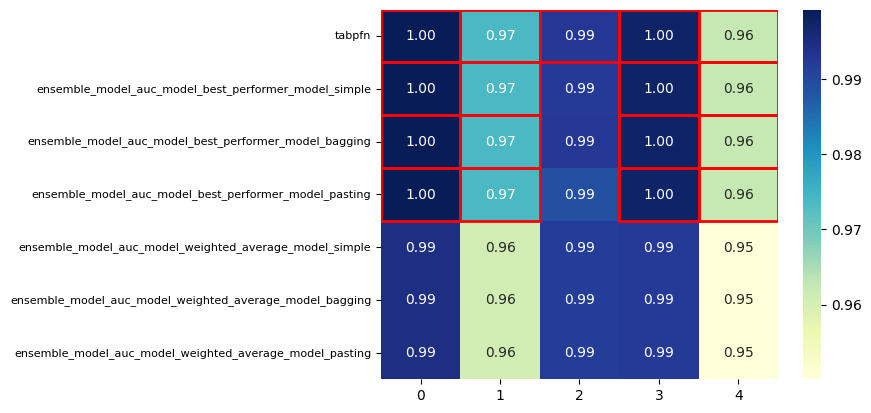

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import ttest_rel

baseline_model = 'baseline'

# Convert the dictionary to a DataFrame
df_data = {model_name: model_metrics['auc'] for model_name, model_metrics in results.items()}
df = pd.DataFrame.from_dict(df_data, orient="index")

# Create the heatmap
ax = sns.heatmap(df, annot=True, fmt=".2f", cmap="YlGnBu")
ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)

# Find the maximum value in each column
max_values = df.max(axis=0)

# Add rectangles for the best performing model in each dataset
for col in range(df.shape[1]):
    highest_indices = np.where(df.iloc[:, col] == max_values[col])[0]
    for row in highest_indices:
        ax.add_patch(plt.Rectangle((col, row), 1, 1, fill=False, edgecolor='red', lw=2))

        model_name = df.index[row]
        if model_name != baseline_model:
            baseline_auc = results[baseline_model]['auc']
            model_auc = results[model_name]['auc']
            t_statistic, p_value = ttest_rel(baseline_auc, model_auc)
            if p_value < 0.05:
                ax.text(col + 0.5, row + 0.5, '*', color='red', fontsize=12, ha='center', va='center')
                print(f"significant: {model_name}")

plt.show()  # Show the plot

In [37]:
import numpy as np
from scipy.stats import ttest_rel

baseline_model = 'tabpfn'
baseline_auc = results[baseline_model]['auc']

for model_name, model_metrics in results.items():
    if model_name == baseline_model:
        continue

    model_auc = model_metrics['auc']
    
    # Perform paired t-test on aggregated auc values
    t_statistic, p_value = ttest_rel(np.hstack(baseline_auc), np.hstack(model_auc))
    
    # Check if the p-value is below a significance threshold (e.g., 0.05)
    if p_value < 0.05:
        print(f"{model_name} is significantly better performing than {baseline_model} across all datasets.")
    else:
        pass
        #print(f"{model_name} is not significantly better performing than {baseline_model} across all datasets.")


ensemble_model_auc_model_weighted_average_model_simple is significantly better performing than tabpfn across all datasets.
ensemble_model_auc_model_weighted_average_model_bagging is significantly better performing than tabpfn across all datasets.
ensemble_model_auc_model_weighted_average_model_pasting is significantly better performing than tabpfn across all datasets.


## Ensemble with ONLY Data Preprocessing Approach


In [11]:
import copy

def deepcopy_excluding_keys(original_dict, keys_to_exclude):
    def copy_without_keys(d, keys):
        new_d = {}
        for key, value in d.items():
            if key not in keys:
                if isinstance(value, dict):
                    new_d[key] = copy_without_keys(value, keys)
                else:
                    new_d[key] = copy.deepcopy(value)
        return new_d

    new_dict = copy_without_keys(original_dict, keys_to_exclude)
    return new_dict


def save_dict_to_pickle_file(dictionary, filename, keys_to_exclude):
    dict_to_plot = deepcopy_excluding_keys(dictionary, keys_to_exclude) 
    
    with open(filename, 'wb') as file:
        pickle.dump(dict_to_plot, file)

In [45]:

def plot_scatter_train_auc_test_auc_best_performer_transformations(dictionary, result_path):
    transformation_best_performer_aucs = {"test_auc": [],
                                          "train_auc": [],
                                          "split_type":[]}
    
    for ensemble_name, ensemble_data in dictionary.items():
        if "best_performer" not in ensemble_name: 
            continue
        split_type = ensemble_name.split("/")[-1]
        for dataset_name, ensemble_dict in ensemble_data.items():
            test_auc = ensemble_dict["auc"]
            train_auc = -1
            
            for model_transformation_key, model_transformation in ensemble_dict["data_ens_dict"].items():
                if model_transformation["data_weight"] == 1:
                    train_auc = model_transformation["data_auc"]
                    break
                    
            transformation_best_performer_aucs["test_auc"].append(test_auc)
            transformation_best_performer_aucs["train_auc"].append(train_auc)
            transformation_best_performer_aucs["split_type"].append(split_type)
              
    data = pd.DataFrame(transformation_best_performer_aucs)

    # Create the scatterplot with hue
    plt.figure(figsize=(8, 6))
    sns_plot = sns.scatterplot(x="train_auc", y="test_auc", hue="split_type", data=data)

    # Fit the linear regression line
    sns_plot = sns.regplot(x="train_auc", y="test_auc", scatter=False, color="gray", data=data)

    # Set axis labels and title
    plt.xlabel("Train AUC")
    plt.ylabel("Test AUC")
    plt.title("Predicted AUC based on train data compared to test AUC on test data of best performer transformation")

    plt.legend(title="Type of Train Split")
    
    # Save the plot to a file
    sns_plot.figure.savefig(result_path, bbox_inches='tight', dpi=500)
    plt.show()


'\nensemble_results["best_performer/bagging"] = {\n        "dataset_name1":{\n            "auc": 0.9,\n            \n            "model_dict": {\n                \'gp_model_1: {\n                    \'model: nn.module\n                    \'model_auc\' :\n                    \'model_weight\' :\n                }\n                \'scm_model_1:{\n                    \'model: nn.module\n                    \'model_auc\':\n                    \'model_weight\':\n                }\n            },\n                \n            "data_ens_dict": {\n                \'gp_model_1_identity\': {\n                    \'train_dat: [x , y]\n                    \'test_data\': x_test\n                    \'test_preds\': preds\n                    \'data_auc\': 0.8\n                    \'data_weight\':0\n                },\n                \n                \'gp_model_1_powertransformer\':{\n                    \'train_data\': [x_t , y_t]\n                    \'test_data\' : x_test_t\n                  

In [46]:

def plot_scatter_train_auc_test_auc_weighted_average_transformations(dictionary, result_path):
    transformation_best_performer_aucs = {"test_auc": [],
                                          "train_auc": [],
                                          "split_type":[]}
    
    for ensemble_name, ensemble_data in dictionary.items():
        if "weighted_average" not in ensemble_name: 
            continue
        split_type = ensemble_name.split("/")[-1]
        for dataset_name, ensemble_dict in ensemble_data.items():
            test_auc = ensemble_dict["auc"]
            train_auc = 0
            
            for model_transformation_key, model_transformation in ensemble_dict["data_ens_dict"].items():
                train_auc += model_transformation["data_weight"] * model_transformation["data_auc"]
                    
            transformation_best_performer_aucs["test_auc"].append(test_auc)
            transformation_best_performer_aucs["train_auc"].append(train_auc)
            transformation_best_performer_aucs["split_type"].append(split_type)
              
    data = pd.DataFrame(transformation_best_performer_aucs)

    # Create the scatterplot with hue
    plt.figure(figsize=(8, 6))
    sns_plot = sns.scatterplot(x="train_auc", y="test_auc", hue="split_type", data=data)

    # Fit the linear regression line
    sns_plot = sns.regplot(x="train_auc", y="test_auc", scatter=False, color="gray", data=data)

    # Set axis labels and title
    plt.xlabel("Train AUC")
    plt.ylabel("Test AUC")
    plt.title("Predicted AUC based on train data compared to test AUC on test data of weighted average transformation")

    plt.legend(title="Type of Train Split")
    
    # Save the plot to a file
    sns_plot.figure.savefig(result_path, bbox_inches='tight', dpi=500)
    plt.show()
    

'\nensemble_results["best_performer/bagging"] = {\n        "dataset_name1":{\n            "auc": 0.9,\n            \n            "model_dict": {\n                \'gp_model_1: {\n                    \'model: nn.module\n                    \'model_auc\' :\n                    \'model_weight\' :\n                }\n                \'scm_model_1:{\n                    \'model: nn.module\n                    \'model_auc\':\n                    \'model_weight\':\n                }\n            },\n                \n            "data_ens_dict": {\n                \'gp_model_1_identity\': {\n                    \'train_dat: [x , y]\n                    \'test_data\': x_test\n                    \'test_preds\': preds\n                    \'data_auc\': 0.8\n                    \'data_weight\':0\n                },\n                \n                \'gp_model_1_powertransformer\':{\n                    \'train_data\': [x_t , y_t]\n                    \'test_data\' : x_test_t\n                  

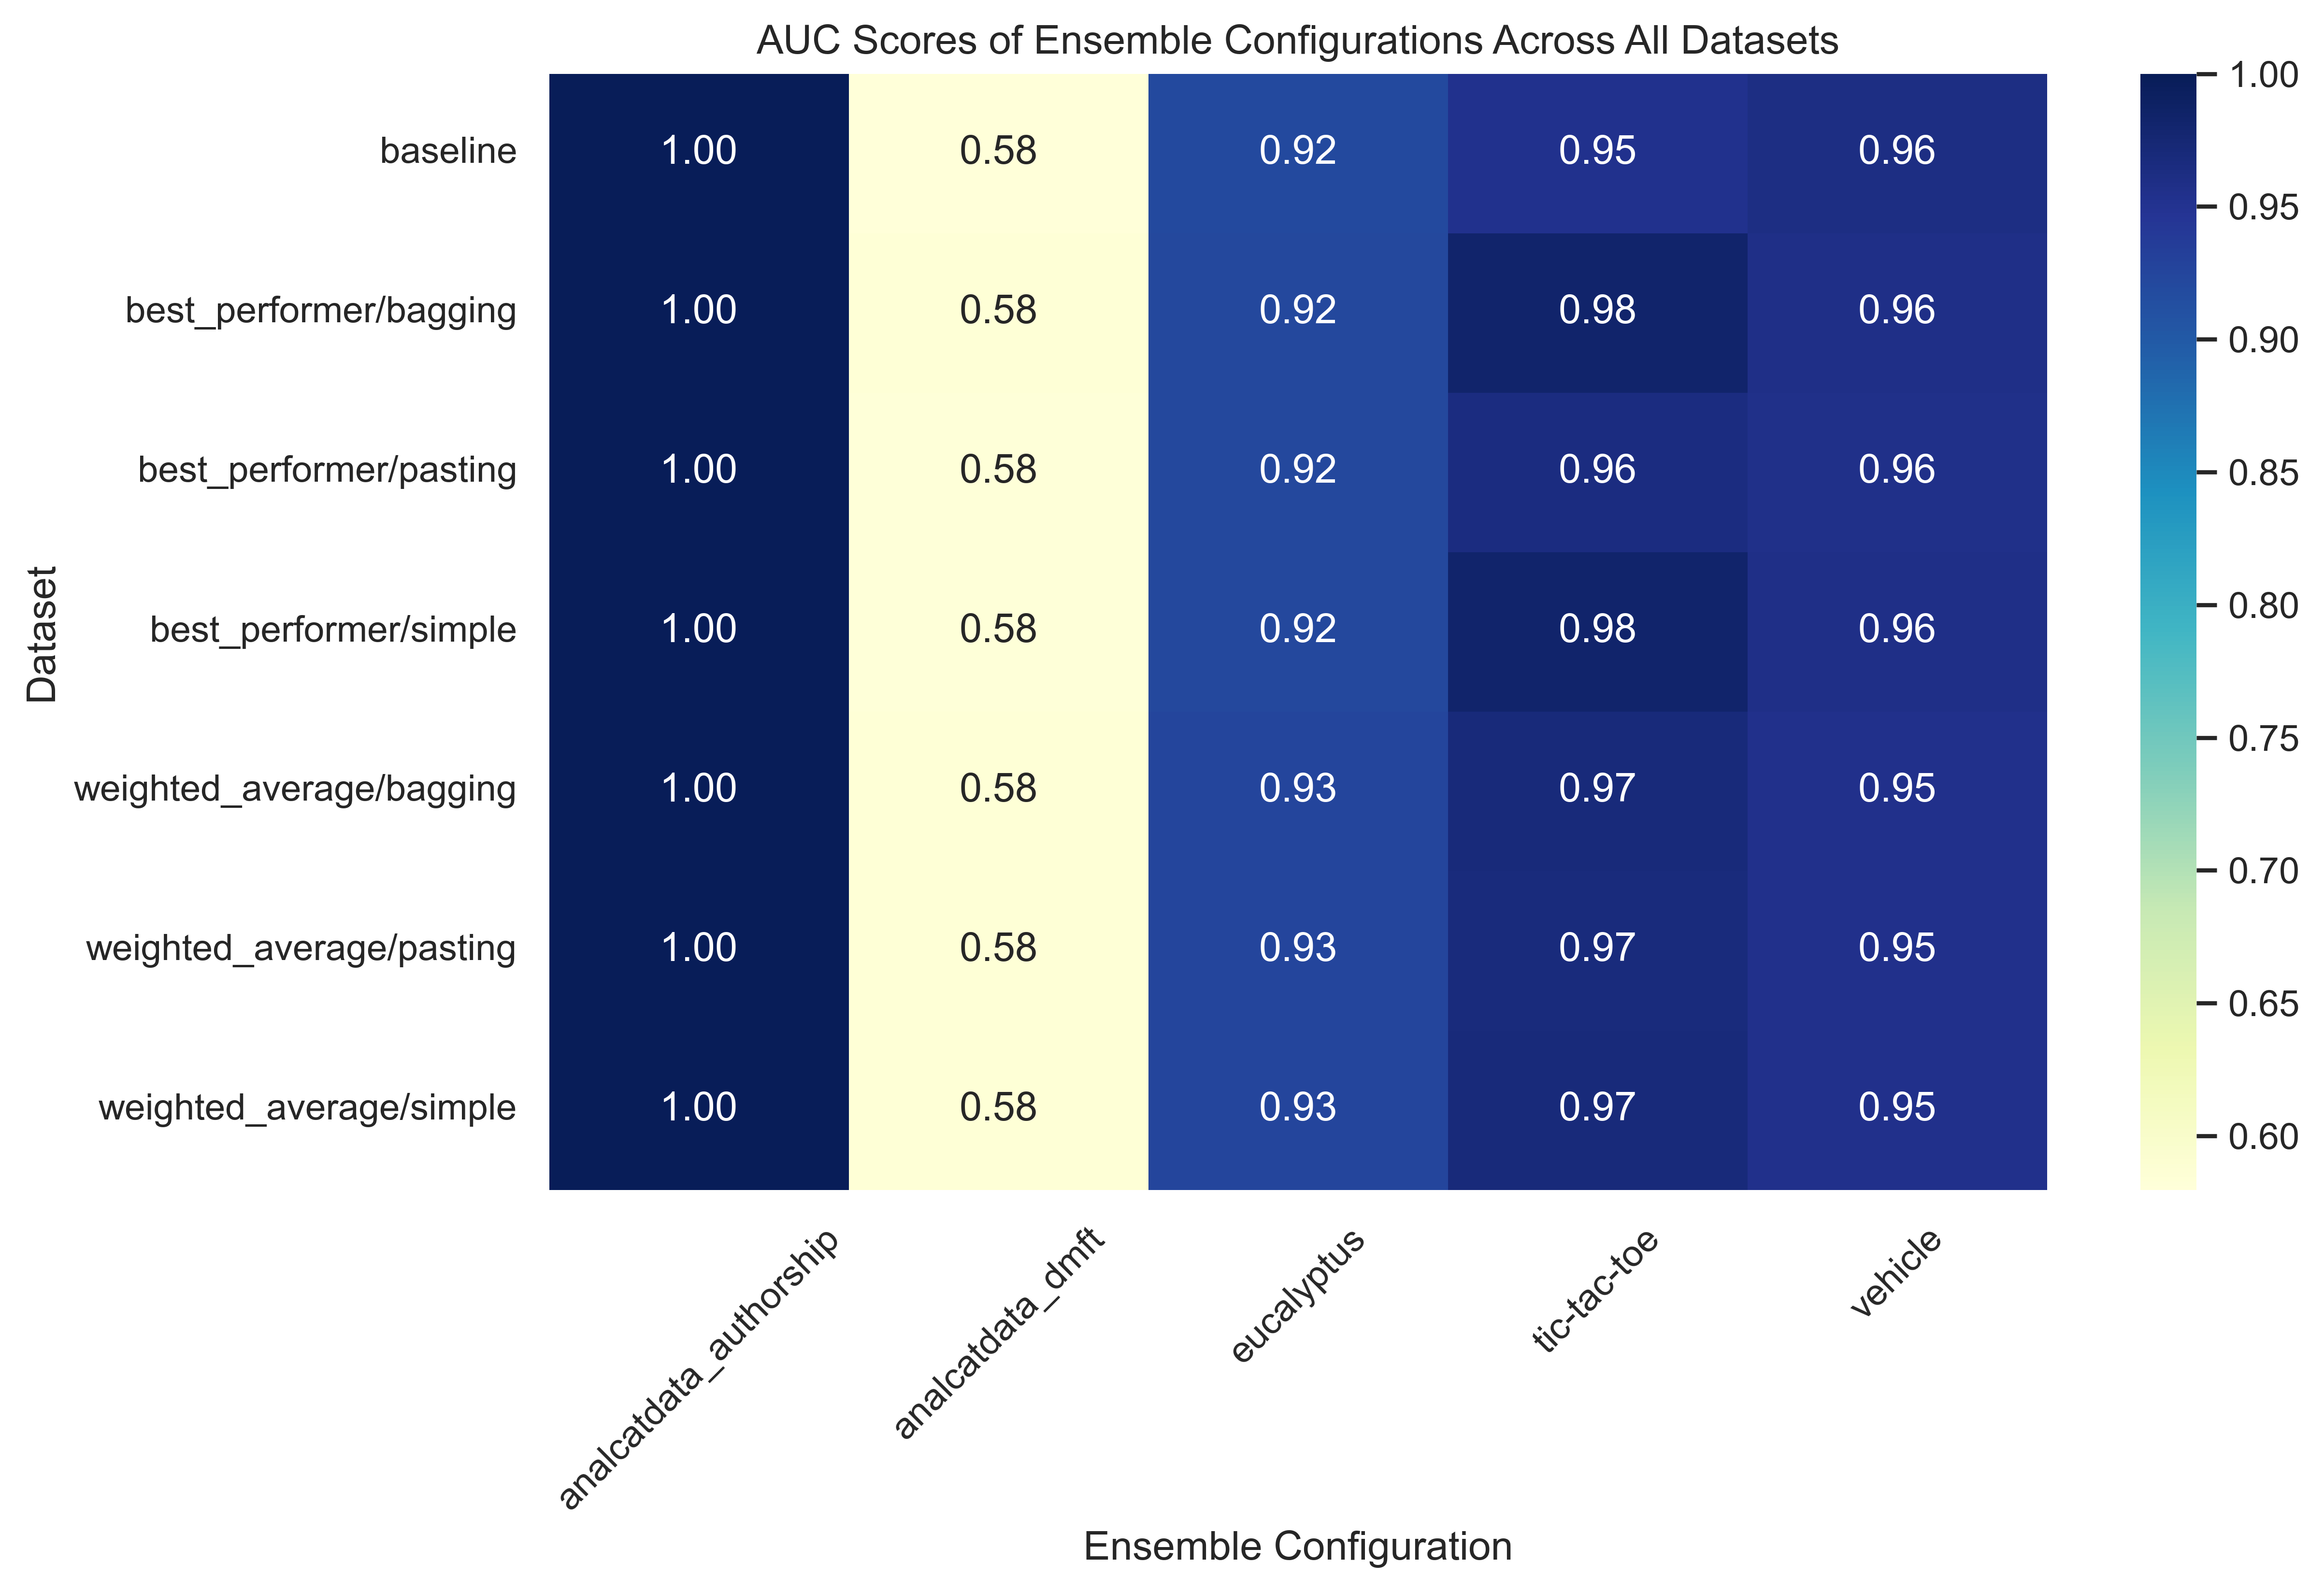

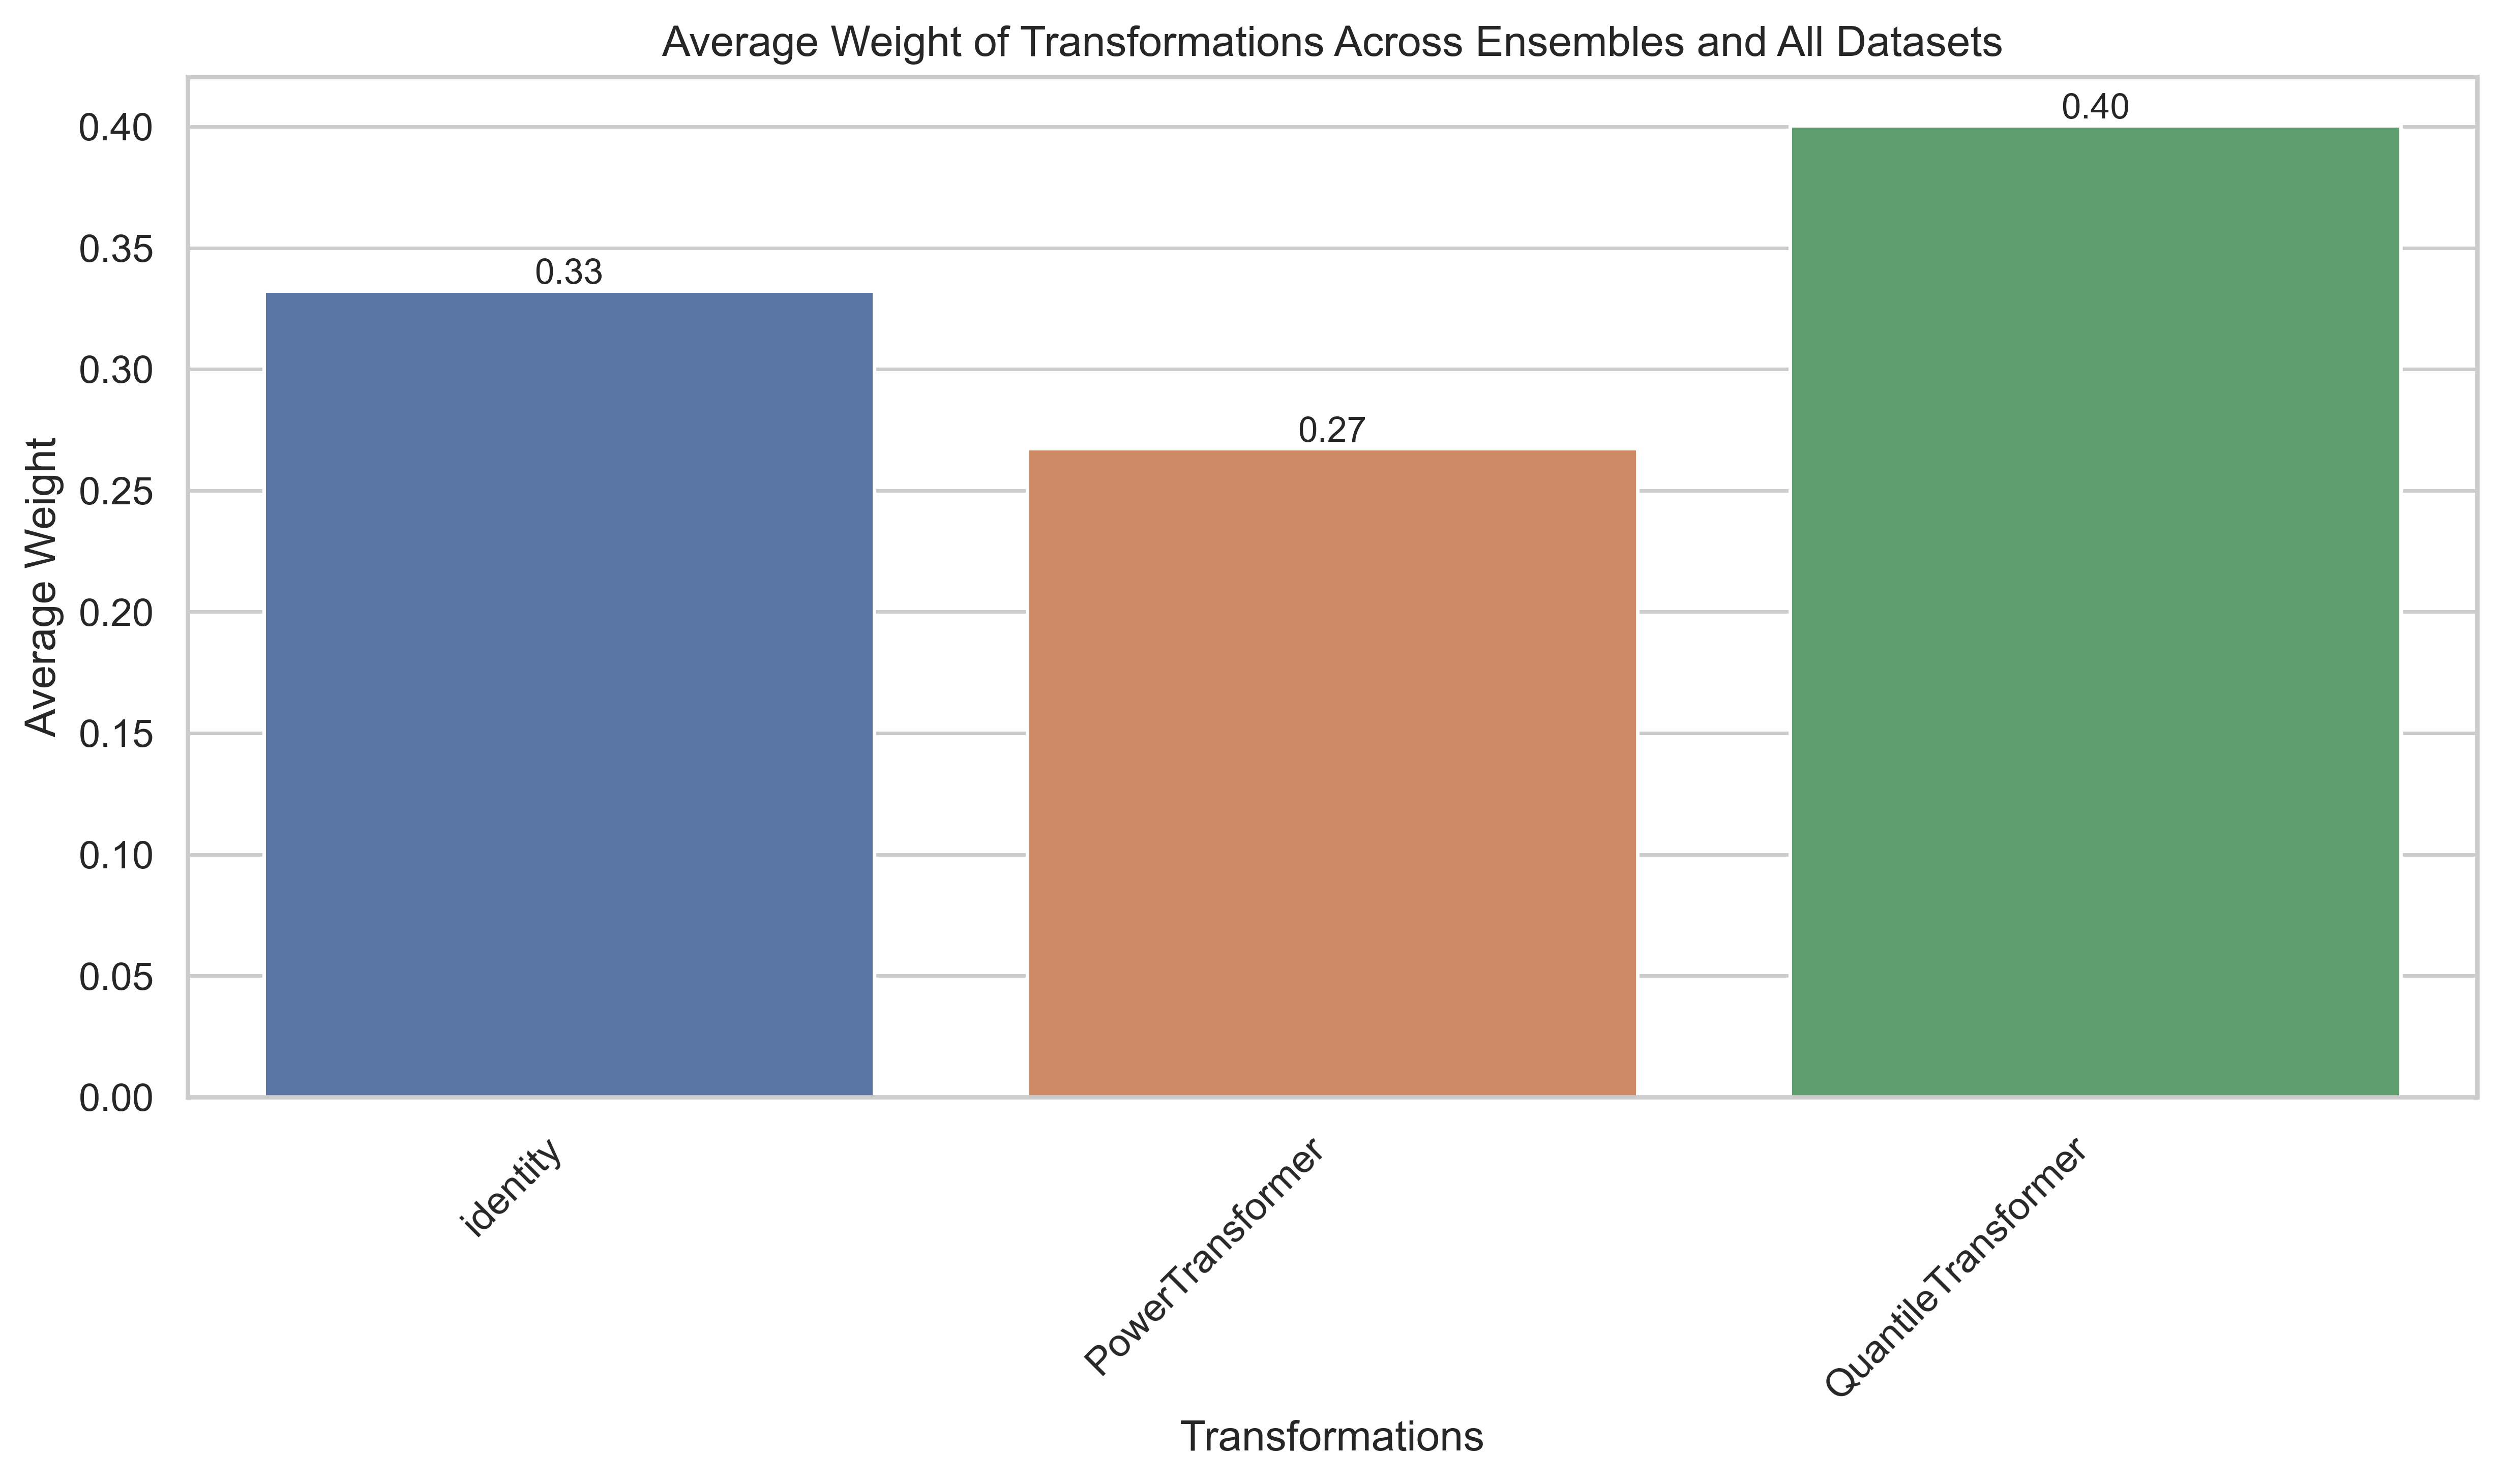

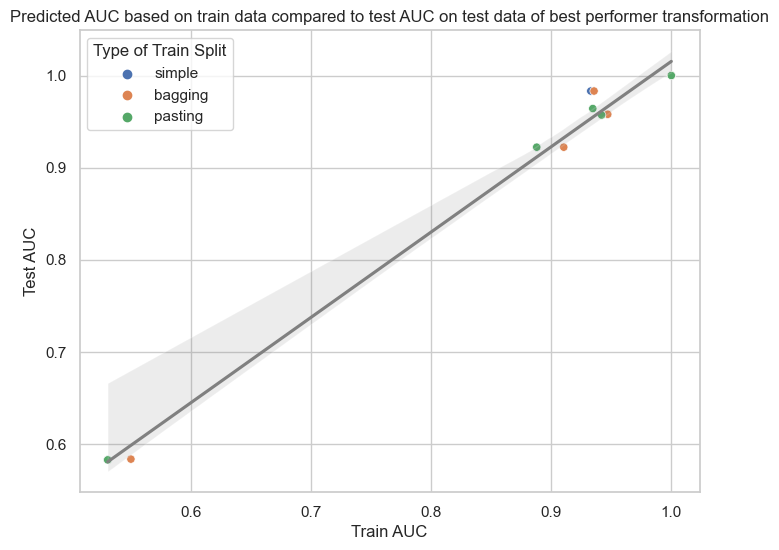

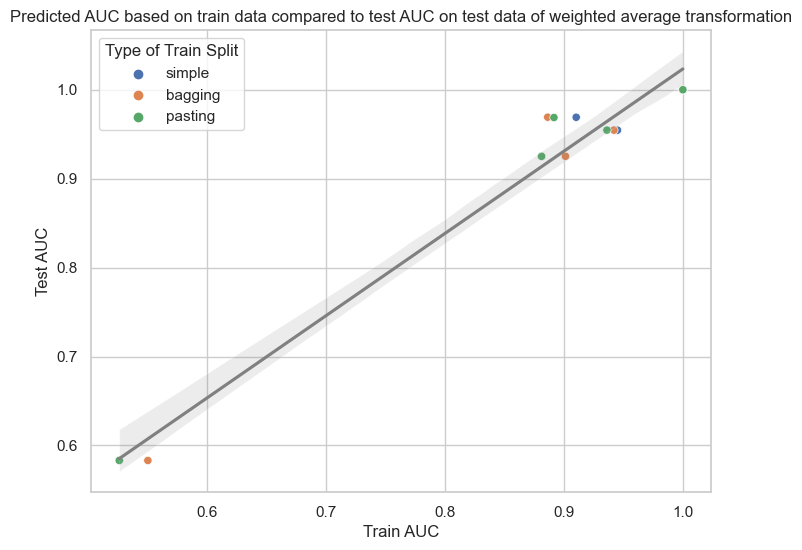

'\nensemble_results["best_performer/bagging"] = {"dataset_name1":{\n"auc": 0.9,\n"model_dict": {\n    \'gp_model_1\': {\n        \'model\': nn.module\n        \'model_auc\' :\n        \'model_weight\' :\n    }\n    \'scm_model_1\':{\n        \'model\': nn.module\n        \'model_auc\' :\n        \'model_weight\' :\n    }\n    \'bag_model_1\':\n    }\n"data_ens_dict": {\n        \'gp_model_1_identity\': {\n            \'train_data\': [x , y]\n            \'test_data\' : x_test\n            \'test_preds\' : preds\n            \'data_auc\' :\n            \'data_weight\' :\n        }\n        \'gp_model_1_powertransformer\':{\n            \'train_data\': [x_t , y_t]\n            \'test_data\' : x_test_t\n            \'data_auc\' :\n            \'data_weight\' :\n        }\n        \'bag_model_1\':\n    }             \n},....}\n'

In [47]:


model_paths = ["./baseline"]




classifier_tabpfn = TabPFNClassifier(device=device, 
                                     base_path="./baseline",
                                     model_string="model_bag_baseline",
                                     N_ensemble_configurations=1,
                                     batch_size_inference=1,
                                     no_preprocess_mode=True,
                                     multiclass_decoder='permutation',
                                     feature_shift_decoder=False)#??? 

weighting_metrics = ["data_auc"]
weight_types = ["best_performer","weighted_average"]# ["weighted_average", "best_performer"]
split_types =["simple", "bagging", "pasting"]
data_preprocess_config = {"N_ensemble_configurations": 1,
                          "sklearn_transformations": [("PowerTransformer",PowerTransformer()),
                                                      ("QuantileTransformer",QuantileTransformer())] } 


ensemble_results = {}


# Indices of the datasets to predict
start = 10
end =  15
number_iterations = range(max(start, 0),min(end,len(test_datasets)))

file_name = "only_data_ensemble_results.pickle"

if os.path.exists(file_name):
    with open(file_name, 'rb') as file:
        ensemble_results = pickle.load(file)
else:
    for dataset_index in number_iterations:

        dataset = test_datasets[dataset_index]
        dataset_name = dataset[0]
        dataset_size = dataset[1].shape

        print(f'Evaluation dataset name: {dataset_name} size {dataset_size} --- {dataset_index}/{len(test_datasets)}')

        xs, ys = dataset[1].clone(), dataset[2].clone()
        #-----------------------------
        # xs = torch.where(torch.isnan(xs), torch.tensor(0.0), xs) # todo same as above 
        # ys = torch.where(torch.isnan(ys), torch.tensor(0), ys.long())
        #-----------------------------
        eval_position = xs.shape[0] // 2
        train_xs, train_ys = xs[0:eval_position], ys[0:eval_position]
        test_xs, test_ys = xs[eval_position:], ys[eval_position:]

        # compare to normal tabpfn

        classifier_tabpfn.fit(train_xs, train_ys)
        prediction_tabpfn = classifier_tabpfn.predict_proba(test_xs)
        auc_baseline = tabular_metrics.auc_metric(test_ys, prediction_tabpfn)

        # add computed results to ensemble_results
        if "baseline" not in ensemble_results:
            ensemble_results["baseline"] = {}

        if dataset_name not in ensemble_results["baseline"]:
            ensemble_results["baseline"][dataset_name] = {}


        baseline_dict = {"auc":auc_baseline.item()}

        ensemble_results["baseline"][dataset_name]= baseline_dict

        # MoE Configurations ---------------------
        for weighting_metric in weighting_metrics: 
            for weight_type in weight_types: 
                for split_type in split_types:
                    print(f"Current configuration: weighting_metric {weighting_metric}, weight_type {weight_type}, split_type {split_type}")

                    data_ensemble_config = {"data_weighting_metric":weighting_metric,
                                            "data_weight_type":weight_type,
                                            "data_split_type":split_type,
                                            "data_split_share":0.5, 
                                            "data_number_splits": 3}

                    
                    # create classifier with configuration 
                    classifier_ensemble = PFNEnsemble(model_storage_folders=model_paths,
                                                      N_ensemble_configurations=data_preprocess_config["N_ensemble_configurations"],
                                                      device=device)

                    classifier_ensemble.fit(train_xs, train_ys)
                    prediction_ = classifier_ensemble.predict_proba(test_xs,
                                                                    model_ensemble_config= None,
                                                                    data_ensemble_config=data_ensemble_config,
                                                                    data_preprocess_config=data_preprocess_config,
                                                                    multiple_models=False,
                                                                    pre_processing=True )

                    auc_ensemble  = tabular_metrics.auc_metric(test_ys, prediction_)

                    # add computed results to results dict
                    ensemble_name = f"{weight_type}/{split_type}"

                    if ensemble_name not in ensemble_results:
                        ensemble_results[ensemble_name] = {}

                    if dataset_name not in ensemble_results[ensemble_name]:
                        ensemble_results[ensemble_name][dataset_name] = {}
                    # ensemble_results = {ensemble_name: {dataset_name:ensemble_dict}
                    ensemble_dict = {"auc":auc_ensemble.item(),
                                    "model_dict":classifier_ensemble.model_dict,
                                    "data_ens_dict":classifier_ensemble.data_ens_dict}

                    ensemble_results[ensemble_name][dataset_name]= ensemble_dict
    save_dict_to_pickle_file(ensemble_results, file_name, keys_to_exclude= ["model", "train_data", "test_data", "test_preds"])





#-----------------------------------------------------------------------
#---------------------------- H E A T M A P ----------------------------

def plot_heatmap_auc_datasets_configs(ensemble_results, dataset_names, result_path):
    # Create lists to store data for the heatmap
    datasets = []
    ensemble_names = []
    auc_scores = []
    
    # Extract data from the ensemble_results dictionary
    for ensemble_name, ensemble_data in ensemble_results.items():
    
        for dataset_name, ensemble_dict in ensemble_data.items():
            datasets.append(dataset_name)
            ensemble_names.append(ensemble_name)
            auc_scores.append(ensemble_dict['auc'])

    # Create a DataFrame from the lists
    df = pd.DataFrame({
        'Ensemble Configuration': ensemble_names,
        'Dataset': datasets,
        'AUC Score': auc_scores
    })

    # Reshape the DataFrame to have "Dataset" as rows, "Ensemble Configuration" as columns, and "AUC Score" as values
 
    df_pivot = df.pivot(index='Ensemble Configuration', columns='Dataset', values='AUC Score')
    # Create the heatmap using seaborn
    plt.figure(figsize=(10, 6))
    sns_plot = sns.heatmap(df_pivot, annot=True, cmap='YlGnBu', fmt=".2f")
    plt.title("AUC Scores of Ensemble Configurations Across All Datasets")
    plt.xlabel("Ensemble Configuration")
    plt.ylabel("Dataset")
    
    plt.setp(sns_plot.get_xticklabels(), rotation=45)
    
    sns_plot.figure.set_dpi(500)
    plt.show()
    sns_plot.figure.savefig(result_path, bbox_inches='tight')
  

    

start = 0
stop = 5
dataset_names = [dataset[0] for dataset_index,dataset in enumerate(test_datasets) if start <= dataset_index <= stop]

plot_heatmap_auc_datasets_configs(ensemble_results, dataset_names, f"dataset[{start}-{stop}]-plot_heatmap_auc_datasets_configs.png" )
#------------------------------------------------------------------------
#------------------------------------------------------------------------

#------------------------------------------------------------------------
#---------------------------- H I S T O G R A M -------------------------
def plot_histogram_average_weights_data_transformations(dictionary, transformation_names, result_path):

    transformation_weight_dict = {}
    for ensemble_name, ensemble_data in dictionary.items():
       
        for dataset_name, ensemble_dict in ensemble_data.items():
            if "data_ens_dict" not in ensemble_dict:
                continue
                
            for model_transformation_key, model_transformation in ensemble_dict["data_ens_dict"].items():
            
                transformation_name = model_transformation_key.split("-")[-1]
                
                if transformation_name not in transformation_weight_dict:
                    transformation_weight_dict[transformation_name] = []
                    
                transformation_weight_dict[transformation_name].append(model_transformation["data_weight"])
                
    for transformation_name, data_weight_list in transformation_weight_dict.items():
        transformation_weight_dict[transformation_name] = sum(transformation_weight_dict[transformation_name]) / len(transformation_weight_dict[transformation_name])

    # Convert the dictionary into two separate lists (x-axis and y-axis)
    transformation_names = list(transformation_weight_dict.keys())
    average_weights = list(transformation_weight_dict.values())

    # Create the histogram using Seaborn's barplot
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    sns_plot = sns.barplot(x=transformation_names, y=average_weights)
    plt.xlabel("Transformations")
    plt.ylabel("Average Weight")
    plt.title("Average Weight of Transformations Across Ensembles and All Datasets")
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    
    # Annotate each bar with its corresponding value
    for index, value in enumerate(average_weights):
        plt.text(index, value, f"{value:.2f}", ha='center', va='bottom', fontsize=10)

    plt.tight_layout()  # Adjust layout to prevent clipping of axis labels    
    sns_plot.figure.set_dpi(500)
    
    plt.show()
    sns_plot.figure.savefig(result_path, bbox_inches='tight')

transformation_names =[ transformation[0] for transformation in data_preprocess_config["sklearn_transformations"]]        
plot_histogram_average_weights_data_transformations(ensemble_results, transformation_names,f"plot_histogram_average_weights_data_transformations.png" )
#------------------------------------------------------------------------
#------------------------------------------------------------------------

#------------------------------------------------------------------------
#---------------------------- S C A T T E R -------------------------
plot_scatter_train_auc_test_auc_best_performer_transformations(ensemble_results, f"plot_scatter_train_auc_test_auc_best_performer_transformations.png")

#------------------------------------------------------------------------

plot_scatter_train_auc_test_auc_weighted_average_transformations(ensemble_results, f"plot_scatter_train_auc_test_auc_weighted_average_transformations.png")

#------------------------------------------------------------------------
#------------------------------------------------------------------------





"""
ensemble_results["best_performer/bagging"] = {"dataset_name1":{
"auc": 0.9,
"model_dict": {
    'gp_model_1': {
        'model': nn.module
        'model_auc' :
        'model_weight' :
    }
    'scm_model_1':{
        'model': nn.module
        'model_auc' :
        'model_weight' :
    }
    'bag_model_1':
    }
"data_ens_dict": {
        'gp_model_1_identity': {
            'train_data': [x , y]
            'test_data' : x_test
            'test_preds' : preds
            'data_auc' :
            'data_weight' :
        }
        'gp_model_1_powertransformer':{
            'train_data': [x_t , y_t]
            'test_data' : x_test_t
            'data_auc' :
            'data_weight' :
        }
        'bag_model_1':
    }             
},....}
"""

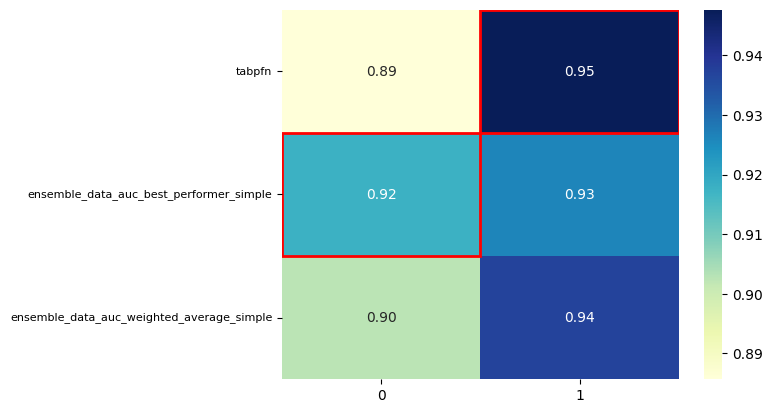

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
baseline_model = 'tabpfn'

# Convert the dictionary to a DataFrame
df_data = {model_name: model_metrics['auc'] for model_name, model_metrics in results.items()}
df = pd.DataFrame.from_dict(df_data, orient="index")

# Create the heatmap
ax = sns.heatmap(df, annot=True, fmt=".2f", cmap="YlGnBu")
ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)

# Find the maximum value in each column
max_values = df.max(axis=0)

# Add rectangles for the best performing model in each dataset
for col in range(df.shape[1]):
    highest_indices = np.where(df.iloc[:, col] == max_values[col])[0]
    for row in highest_indices:
        ax.add_patch(plt.Rectangle((col, row), 1, 1, fill=False, edgecolor='red', lw=2))

        model_name = df.index[row]
        if model_name != baseline_model:
            baseline_auc = results[baseline_model]['auc']
            model_auc = results[model_name]['auc']
            t_statistic, p_value = ttest_rel(model_auc, baseline_auc, alternative='greater')
            if p_value < 0.05:
                ax.text(col + 0.5, row + 0.5, '*', color='red', fontsize=12, ha='center', va='center')
                print(f"significant: {model_name}")

plt.show()  # Show the plot

In [22]:
import numpy as np
from scipy.stats import ttest_rel

baseline_model = 'tabpfn'
baseline_auc = results[baseline_model]['auc']

for model_name, model_metrics in results.items():
    if model_name == baseline_model:
        continue

    model_auc = model_metrics['auc']
    
    # Perform paired t-test on aggregated auc values
    t_statistic, p_value = ttest_rel(np.hstack(baseline_auc), np.hstack(model_auc))
    
    # Check if the p-value is below a significance threshold (e.g., 0.05)
    
    print(p_value)
        print(f"{model_name} is significantly better performing than {baseline_model} across all datasets.")
    else:
        pass
        #print(f"{model_name} is not significantly better performing than {baseline_model} across all datasets.")


0.2504492931462494
0.2504492931462494
0.2504492931462494
0.25029597848757784
0.2504492931462494
0.25029597848757784
0.2504492931462494
0.2504492931462494
0.2504492931462494
0.2504492931462494
0.25034398021423465
0.2504492931462494


# Combined Data and Expert Ensembling

In [52]:
import traceback
import time
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
model_paths = ["./models_gp","./models_causal","./baseline"]    

classifier_tabpfn = TabPFNClassifier(device=device, 
                                     base_path="./baseline",
                                     model_string="downloaded_tabpfn",
                                     N_ensemble_configurations=1,
                                     batch_size_inference=1, 
                                     no_preprocess_mode=True,
                                     multiclass_decoder='permutation',
                                     feature_shift_decoder=False)#??? 

data_weighting_metrics = ["data_auc"]  
data_weight_types = ["data_best_performer","data_weighted_average"] 
data_split_types =["data_simple", "data_bagging", "data_pasting"] 

model_weighting_metrics = ["model_auc"]  
model_weight_types = ["model_best_performer","model_weighted_average"] 
model_split_types =["model_simple", "model_bagging", "model_pasting"] 


results = {}
best_performers = []

start = 10
end =  12
number_iterations = range(max(start, 0),min(end,len(test_datasets)))# Index of the dataset to predict

for evaluation_dataset_index in number_iterations:
    ds = test_datasets[evaluation_dataset_index]
    print(f'Evaluation dataset name: {ds[0]} shape {ds[1].shape} --- {evaluation_dataset_index}/{len(test_datasets)}')

    xs, ys = ds[1].clone(), ds[2].clone()
    #-----------------------------
    xs = torch.where(torch.isnan(xs), torch.tensor(0.0), xs)
    ys = torch.where(torch.isnan(ys), torch.tensor(0), ys.long())
    #-----------------------------
    eval_position = xs.shape[0] // 2
    train_xs, train_ys = xs[0:eval_position], ys[0:eval_position]
    test_xs, test_ys = xs[eval_position:], ys[eval_position:]
    
    # compare to normal tabpfn
 
    classifier_tabpfn.fit(train_xs, train_ys)
    prediction_tabpfn = classifier_tabpfn.predict_proba(test_xs)
    auc_tabpfn = float(tabular_metrics.auc_metric(test_ys, prediction_tabpfn))
    
    # add computed results to result dict
    if "tabpfn" not in results:
        results["tabpfn"] = {}
        results["tabpfn"]["auc"] = np.zeros(len(number_iterations))
    results["tabpfn"]["auc"][evaluation_dataset_index - start] = auc_tabpfn
        
    # MoE Configurations ---------------------
    for model_weighting_metric in model_weighting_metrics: 
        for model_weight_type in model_weight_types: 
            for model_split_type in model_split_types:
                print(f"Current model_configuration: model_weighting_metric {model_weighting_metric}, model_weight_type {model_weight_type}, model_split_type {model_split_type}")
                # --------------------------------
                model_ensemble_config = {"model_weighting_metric":model_weighting_metric,
                                         "model_weight_type":model_weight_type,
                                         "model_split_type":model_split_type,
                                         "model_split_share":0.5, 
                                         "model_number_splits": 5}
                
                data_preprocess_config = {"N_ensemble_configurations": 5,
                                          "sklearn_transformations": [("PowerTransformer",PowerTransformer()),
                                                                      ("QuantileTransformer",QuantileTransformer())]} 
                
                # create classifier with configuration 
                classifier_ensemble = PFNEnsemble(model_storage_folders=model_paths,
                                           N_ensemble_configurations=data_preprocess_config["N_ensemble_configurations"],
                                           device=device)
                
                for data_weighting_metric in data_weighting_metrics: 
                        for data_weight_type in data_weight_types: 
                            for data_split_type in data_split_types:
                                
                                data_ensemble_config = {"data_weighting_metric":data_weighting_metric,
                                                        "data_weight_type":data_weight_type,
                                                        "data_split_type":data_split_type,
                                                        "data_split_share":0.5, 
                                                        "data_number_splits": 5}
                
                                classifier_ensemble.fit(train_xs, train_ys)
                                prediction_ = classifier_ensemble.predict_proba(test_xs,
                                                                                model_ensemble_config=model_ensemble_config,
                                                                                data_ensemble_config=data_ensemble_config,
                                                                                data_preprocess_config=data_preprocess_config,
                                                                                multiple_models=True,
                                                                                pre_processing=True)
                        
                                auc_ensemble = tabular_metrics.auc_metric(test_ys, prediction_)
                            
                                # add computed results to results dict
                                key_name = f"ensemble_{weighting_metric}_{weight_type}_{split_type}"
                                if key_name not in results:
                                    results[key_name] = {}
                                    results[key_name]["auc"] = np.zeros(len(number_iterations))
                                results[key_name]["auc"][evaluation_dataset_index - start] = auc_ensemble 

Evaluation dataset name: tic-tac-toe shape torch.Size([958, 9]) --- 10/30
Current model_configuration: model_weighting_metric model_auc, model_weight_type model_best_performer, model_split_type model_simple
TODO data preprocessing and moe both used!
aug_weights_dict: {'PowerTransformer': {'data_auc': 0.8840579710144927, 'data_weight': 0}, 'QuantileTransformer': {'data_auc': 0.9199932197643867, 'data_weight': 1}, 'identity': {'data_auc': 0.8629544876684465, 'data_weight': 0}}
aug_weights_dict: {'PowerTransformer': {'data_auc': 0.8766844647851513, 'data_weight': 0}, 'QuantileTransformer': {'data_auc': 0.9058394779218578, 'data_weight': 1}, 'identity': {'data_auc': 0.8594796169166878, 'data_weight': 0}}


KeyboardInterrupt: 